In [1]:
from time import perf_counter
import os
# from joblib import Parallel, delayed
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx

from src import utils
from src import models

SEED = 10
N_CPUS = os.cpu_count()
SAVE = True
SAVE_CSV = True
DECIMATE = 5
PATH = './results/finantial/finantial'
# np.random.seed(SEED)

In [2]:
def visualize_data(data, title):
    fig, axes = plt.subplots(1,4, figsize=(16, 4))
    
    Cov = data @ data.T / data.shape[1]
    mean_data = data.mean(axis=0)
    data_dif = np.array( [mean_data[i] - mean_data[i-1] for i in range(1, data.shape[1])] )

    axes[0].plot(data.T)
    axes[0].set_title(title)
    axes[0].grid(True)

    axes[1].plot(mean_data)
    axes[1].set_title(title + ' - mean')
    axes[1].grid(True)

    axes[2].plot(data_dif)
    axes[2].set_title(title + ' - diff')
    axes[2].grid(True)

    im  = axes[3].imshow(Cov)
    fig.colorbar(im, ax=axes[3])



def get_list_data(data, sizes, samples):
    if isinstance(samples, int):
        samples = [samples]

    # TODO: properly check data
    assert len(sizes) == len(samples)
    if np.sum(sizes) != data.shape[0]:
        print('WARNING: more nodes available')

    if np.sum(samples) != data.shape[1]:
        print('WARNING: there are more observations available')

    n_nodes = 0
    offset = 0
    data_list = []
    for i, new_nodes in enumerate(sizes):
        n_nodes += new_nodes
        n_samples = samples[i] + offset
        data_list.append( data[:n_nodes, offset:n_samples] )
        offset = n_samples
    return data_list


def run_experiment(Exps, data, sizes, samples, def_args, verb=True):
    X_list = get_list_data(data, sizes, samples)
    n_nodes = data.shape[0]
    n_samples = np.array( [X_i.shape[1] for X_i in X_list] ).sum()

    runtime = np.zeros(len(Exps))
    models_fit = []
    for i, exp in enumerate(Exps):
        args_aux = {**def_args, **exp['args']} if 'args' in exp.keys() else {**def_args}
        args_aux['lamb'] = utils.lamb_value(n_nodes, n_samples, args_aux['lamb'])
        model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
        t_init = perf_counter()
        model.fit(X_list, **args_aux)
        t_end = perf_counter()

        if i == 0:
            Adjs_off = model.S_seq.copy()

        runtime[i] = t_end - t_init
        models_fit.append( model ) 

        norm_A = np.linalg.norm( model.S_seq[-1][-1] )
        if verb:
            print(f'- {exp["leg"]}: time: {runtime[i]:.3f} secs  -  norm A: {norm_A:.3f}')            
        
    return models_fit, Adjs_off, runtime

def compute_errs(models_fit, Adjs_off, n_samples):
    err_wrt_off = np.zeros((n_samples, len(models_fit)))
    regret = np.zeros((n_samples, len(models_fit)))

    

    for i, model in enumerate(models_fit):
        print('norm Adj_off', i, np.linalg.norm(Adjs_off[-1][-1]))
        print('norm Adj', i, np.linalg.norm(model.S_seq[-1][-1]))
        
        print('diff Adj', i, np.linalg.norm(Adjs_off[-1][-1] - model.S_seq[-1][-1]))
        err_wrt_off[:,i], regret[:,i] = model.regret(Adjs_off) 

    return err_wrt_off,regret

def binarize(Adj, th):
    mask = np.ones(Adj.shape[0]) - np.eye(Adj.shape[0])
    Adj_bin = Adj*mask
    Adj_bin[np.abs(Adj_bin) < th] = 0
    Adj_bin[np.abs(Adj_bin) > th] = 1
    return Adj_bin

def prune_edges(A, max_edges):
    mask = np.ones(A.shape[0]) - np.eye(A.shape[0])
    A = mask*A
    sorted_edges = np.sort(np.abs(A).flatten())[::-1]
    A_aux = np.copy(A)
    A_aux[A_aux < sorted_edges[max_edges]] = 0
    return A_aux

def plot_graphs(model, idxs, title, th=.2, color_ths=1.2, prune=None, layout='spring', save_file=None):
    fig, axes = plt.subplots(1, len(idxs), figsize=(4*len(idxs), 4))

    if prune is not None:
        S_bin = prune_edges(model.S_seq[-1][-1], prune)
    else:
        S_bin = binarize(model.S_seq[-1][-1], th)
        
    if layout == 'circular':
        pos_last = nx.circular_layout(nx.Graph(S_bin))
    else:
        pos_last = nx.spring_layout(nx.Graph(S_bin))

    # Get max_val    
    for i, idx in enumerate(idxs):
        if prune is not None:
            S_bin = prune_edges(model.S_seq[idx[0]][idx[1]], prune)
        else:
            S_bin = binarize(model.S_seq[idx[0]][idx[1]], th)
        nodes = S_bin.shape[0]

        # if idx[0] > 0:
        if i > 0:
            idx_prev = idxs[i-1]
            new_nodes = model.S_seq[idx[0]][idx[1]].shape[0] - model.S_seq[idx_prev[0]][idx_prev[1]].shape[0]
        else:
            new_nodes = 0

        pos = {}
        for key, value in pos_last.items():
            if key == nodes:
                break
            pos[key] = value
        
        axes[i].axis('off')
        nx.draw_networkx_edges(nx.Graph(S_bin), 
                            alpha=.6,
                            pos=pos, width=.7,
                            ax = axes[i],
                            # edge_color=edge_color,
                            # edge_cmap=cmap, 
                            # edge_vmin=A_nti_pred.max()*0, 
                            # edge_vmax=A_nti_pred.max()*.3
                            )
        nx.draw_networkx_nodes(nx.Graph(S_bin), 
                            pos=pos, node_size=150, linewidths=1,
                            ax = axes[i],
                            # edgecolors=edge_list
                            )
        axes[i].set_title(f'{title} - ({idx[0]},{idx[1]})')

    if save_file is not None:
        fig.savefig(save_file)
        print('Saved as:', save_file)


def decimate_data(data, dec):
    xaxis = np.arange(data.size)

    if dec == 0:
        return data, xaxis
    
    idxs = np.arange(xaxis[0], xaxis[-1]+1, dec-1)
    data = data[idxs]
    xaxis = xaxis[idxs]

    return data, xaxis

## Load and visualize data

Data shape: (15, 1206)
Saved:  ./results/finantial/finantial_stocks_med.csv


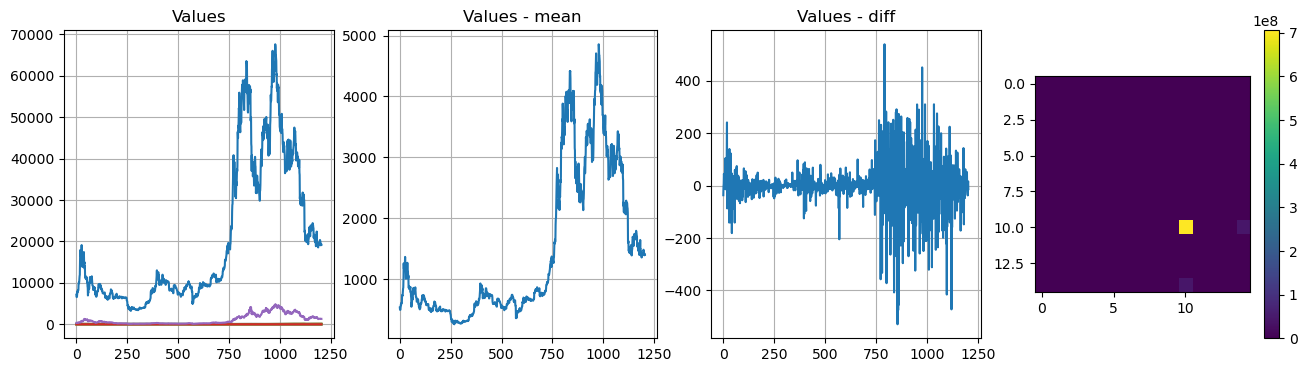

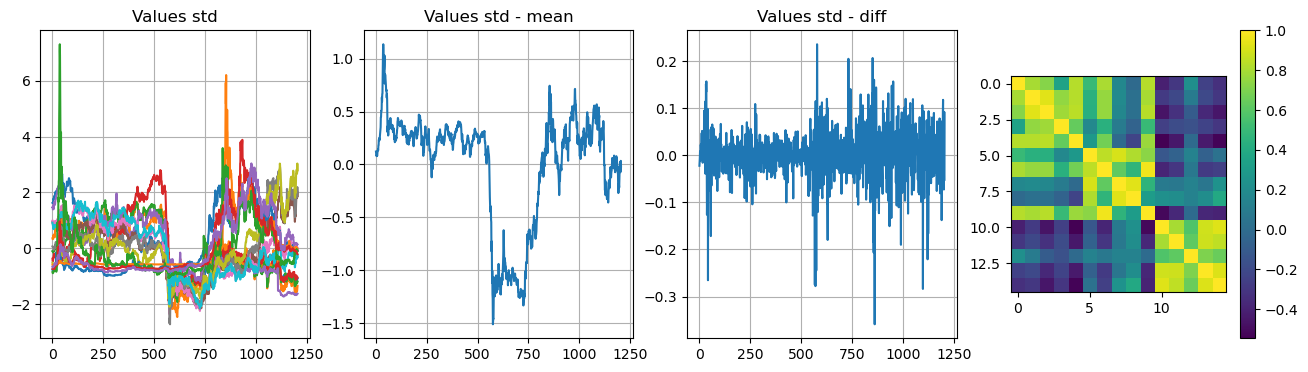

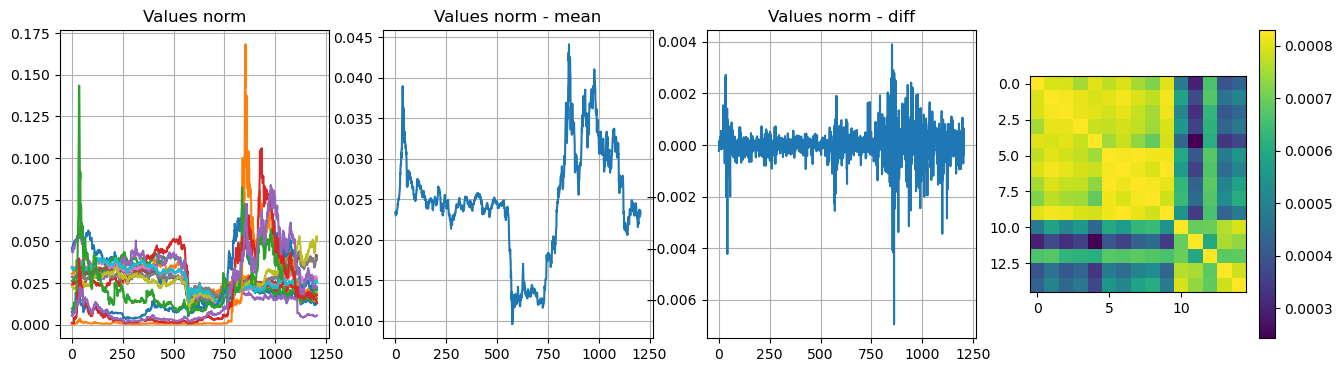

In [3]:
mat_data = scipy.io.loadmat('Finantial/m_X_air_OIL_CRYP2.mat')['m_X']

# Normalize
standarize = lambda X: (X - np.nanmean(X, axis=1, keepdims=True)) / np.nanstd(X, axis=1, keepdims=True)
normalize = lambda X: X / np.linalg.norm(X, axis=1, keepdims=True)
mat_data_std = standarize(mat_data)
mat_data_norm = normalize(mat_data)

print('Data shape:', mat_data.shape)

visualize_data(mat_data, 'Values')
visualize_data(mat_data_std, 'Values std')
visualize_data(mat_data_norm, 'Values norm')

if SAVE:
    fname = PATH + '_stocks_med.csv'
    header = 'xaxis; stocks'
    med_data, xaxis = decimate_data( np.median(mat_data_std, axis=0), DECIMATE )
    data = np.concatenate((xaxis.reshape(-1, 1), med_data.reshape(-1, 1)), axis=1)
    np.savetxt(fname, data, delimiter=';', header=header, comments='')
    print('Saved: ', fname)

    fname = PATH + '_stocks_prct25.csv'
    prctile25, xaxis = decimate_data( np.percentile(mat_data_std, 25, axis=0), DECIMATE )
    data = np.concatenate((xaxis.reshape(-1, 1), prctile25.reshape(-1, 1)), axis=1)
    np.savetxt(fname, data, delimiter=';', header=header, comments='')

    fname = PATH + '_stocks_prct75.csv'
    prctile75, xaxis = decimate_data( np.percentile(mat_data_std, 75, axis=0), DECIMATE )
    data = np.concatenate((xaxis.reshape(-1, 1), prctile75.reshape(-1, 1)), axis=1)
    np.savetxt(fname, data, delimiter=';', header=header, comments='')

In [4]:
# Data params
sizes = [13, 2]
samples = [750, 456]
# samples = [500, 706]


# Model parameters
verb = True
COLD_START = False
OFFLINE_ITERS = 100
update = 'incr'
default_args = {
    'iters_sample': 1,
    'lamb': 7, #1e-2,
    'stepsize': 7e-3,
    'gamma':  .99,
    'epsilon': .01,  #1,
    'alpha': 0,
    'nonneg_proj': True
}

Exps = [
    # {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic', 'h': .8}, 'args': {'iters_sample': OFFLINE_ITERS, 'epsilon': .05, 'stepsize': 1e-3, 'lamb': 2}, 'leg': f'Off', 'fmt': '-'}, # Best
    # {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic', 'h': .8}, 'args': {'epsilon': .01, 'stepsize': 1e-3, 'lamb': 2}, 'leg': f'Exp', 'fmt': '-'}, # Best

    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic', 'h': .7}, 'args': {'iters_sample': OFFLINE_ITERS}, 'leg': f'Off', 'fmt': '-'}, # Best
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic', 'h': .7}, 'args': {'iters_sample': 3}, 'leg': f'Exp', 'fmt': '-'}, # Best

]
models_fit, Adjs_off, runtime = run_experiment(Exps, mat_data_std, sizes, samples, default_args, verb)


- Off: time: 14.054 secs  -  norm A: 9.327
- Exp: time: 0.436 secs  -  norm A: 6.672


norm Adj_off 0 9.32662498808228
norm Adj 0 6.671608864733063
diff Adj 0 3.3784094725639893
Saved as: fatality.png
Saved:  ./results/finantial/finantial_err_med.csv
Saved:  ./results/finantial/finantial_regret_med.csv


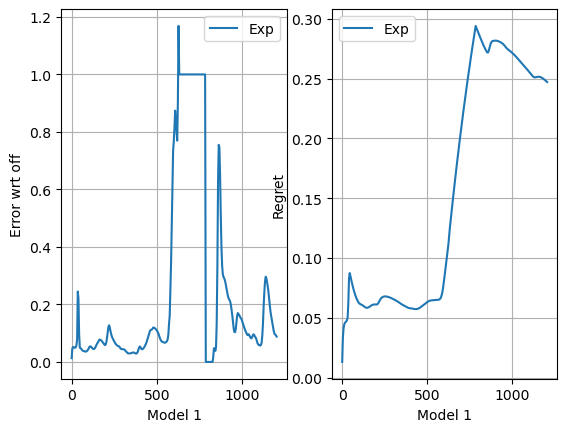

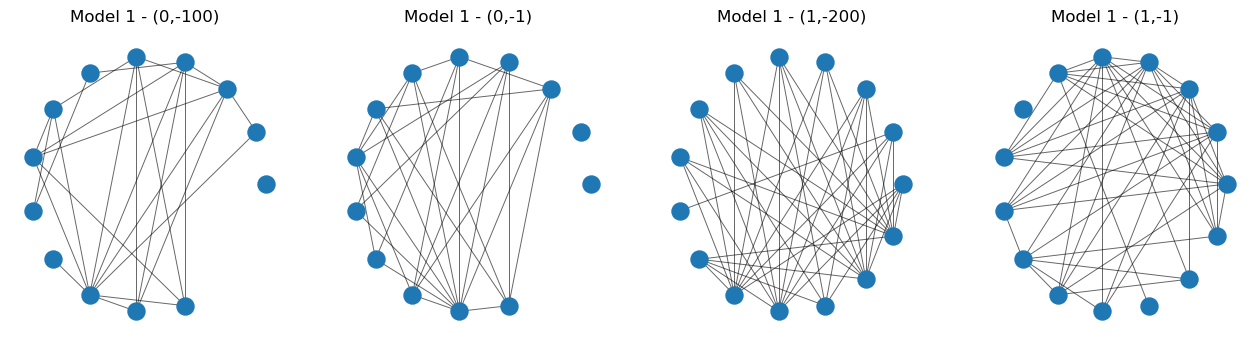

In [5]:
i = 1
model = models_fit[i]

idxs = [(0,-100), (0,-1), (1,-200), (1,-1)]

err_off, regret = compute_errs([model], Adjs_off, np.sum(samples))
fig, axes = plt.subplots(1,2)
utils.plot_data(axes[0], err_off, [Exps[i]], np.arange(err_off.shape[0]), f'Model {i}', 'Error wrt off',
                        agg=None, deviation='none', dec=DECIMATE)
utils.plot_data(axes[1], regret, [Exps[i]], np.arange(regret.shape[0]), f'Model {i}', 'Regret',
                        agg=None, deviation='none', dec=DECIMATE)

plot_graphs(model, idxs, f'Model {i}', th=0, prune=100, layout='circular', save_file='fatality.png')

if SAVE:
    fname = PATH + '_err_med.csv'
    header = 'xaxis; err'
    med_data, xaxis = decimate_data( np.median(err_off, axis=0), DECIMATE )
    data = np.concatenate((xaxis.reshape(-1, 1), med_data.reshape(-1, 1)), axis=1)
    np.savetxt(fname, data, delimiter=';', header=header, comments='')
    print('Saved: ', fname)

    fname = PATH + '_regret_med.csv'
    header = 'xaxis; err'
    med_data, xaxis = decimate_data( np.median(regret, axis=0), DECIMATE )
    data = np.concatenate((xaxis.reshape(-1, 1), med_data.reshape(-1, 1)), axis=1)
    np.savetxt(fname, data, delimiter=';', header=header, comments='')
    print('Saved: ', fname)